# Predictive models in neuroscience
We've already taken a look at our raw data and gotten a feel for what kinds of spectral activity (in the brain) might be responsive to sound features. Now, we'll get at this more closely by building an *encoding model*.

The basic idea of a "decoding" model is as follows:

1. there is information about the world embedded within the brain activity (because the brain is responding to the world around it).
2. We can record brain activity and whatever was happening in the world to build a model for the relationship between the brain/world.
3. We can use this model to make predictions about how the brain should respond to new sound features.
4. If this works well, then we can investigate the model to see what kinds of sound features a brain region is responsive to.

## Background reading
There are a LOT of papers out there that use predictive models, but relatively few that are easy to understand. Here are a few suggestions:

* At the highest level, you might want to check out [this review from Theunissen](http://www.nature.com/nrn/journal/v15/n6/full/nrn3731.html) and [this one from Buszaki](http://www.nature.com/nrn/journal/v13/n6/full/nrn3241.html). The first covers encoding models of the brain more generally, and the second is about extracellular fields.
* To learn specifically about modeling in the brain, I'd check out [this nice review paper](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3037423/) from the Gallant lab. It's called "Encoding and Decoding in fMRI", and is a general review paper about the world of encoding/decoding. It's a good start to get a general overview of the methods. Also, it's got a picture of Rambo riding a unicorn, which is pretty awesome.
* If you're interested in diving a bit further, check out [this paper](http://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1001251) from Brian Pasley. It is one of the first "decoding" papers in electrophysiology. In it, Pasley uses predictive models along with brain activity in order to decode what speech a person is listening to. It's got more detail about the methods and analysis.
* Finally, a really nice explanation of linear models and this particular class of "encoding model" techniques is [Willmore's paper on first-order kernel estimation](http://www.ncbi.nlm.nih.gov/pubmed/12938771). It's the most concise and straightforward paper that I've found.
* That said, a good place to start is looking through machine learning blogs and documentation for packages like scikit-learn. This is a good way to learn about predictive models in general.

## Now on to the data
We've collected a dataset where the subject was listening to spoken sentences. We have an audio file with those sentences, a brain file with their brain activity, and a list of times for when the sentences began. (actually, rather than a raw audio file we have a spectrogram of audio, but we'll get to that later).

We've previously found that **high-gamma** activity is particularly responsive to sound features. We'll load the raw ecog data, and then extract the high-gamma frequency band for fitting our models.

In [1]:
import mne
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ecogtools as et
import seaborn as sns
sns.set_style('white')

# This ensures that you'll be able to use interactive plots
%matplotlib notebook

/Users/choldgraf/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag(

In [2]:
# These are stored as "fif" files, which MNE reads easily
brain = mne.io.Raw('./data/ecog_clean_raw.fif', add_eeg_ref=False, preload=True)
audio = mne.io.Raw('./data/spectrogram.fif', add_eeg_ref=False, preload=True)

/Users/choldgraf/src/python/mne-python/mne/utils.py:268: UserWarning: This filename (/Users/choldgraf/gdrive/github/personal/writeups/neuro/ecog/data/spectrogram.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  '%s' % (fname, filetype, print_endings))


In [4]:
# Load our times file, which is stored as a CSV of events
mtime = pd.read_csv('./data/time_info.csv', index_col=0)

# Pull only the trials we care about
mtime = mtime.query('t_type=="mid" and t_num > 0')

# These are the start/stop times for sound
mtime.head()

/Users/choldgraf/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:90: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:667: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


,start,stop,_notes,t_type,t_num,filt_type,kind,id,noise_stim
7,44.111375,47.144813,NaN,mid,1,norm,trial,7,none
10,62.315312,64.253875,NaN,mid,2,norm,trial,10,none
13,76.878563,78.971688,NaN,mid,3,norm,trial,13,none
16,88.910438,91.821500,NaN,mid,4,norm,trial,16,none
19,106.426937,109.531188,NaN,mid,5,norm,trial,19,none


Now, we'll do some filtering to pull out high-gamma activity. We'll filter a few sub-bands of high-gamma, and then average them together. This reduces the variability in the signal, and since people mostly think that high-gamma is the same across all frequencies > 70Hz or so, it should be OK to do.

In [23]:
from scipy.signal import hilbert, decimate

In [39]:
    filt_data = mne.filter.band_pass_filter(
        brain._data, brain.info['sfreq'], *fband)

In [40]:
filt_data.shape

(64, 815001)

In [43]:
# We'll also add zeros to our data so that it's of a length 2**N.
# In signal processing, everything goes faster if your data is length 2**N
next_pow2 = int(np.ceil(np.log2(brain.n_times)))
filter_bands = [(70, 100), (100, 130), (130, 160)]

# Loop through each frequency band
brain_hg = []
for fband in filter_bands:
    # First bandpass filter
    filt_data = mne.filter.band_pass_filter(
        brain._data, brain.info['sfreq'], *fband)
    
    # Now take the hilbert transform / absolute value to get the amplitude
    filt_data = np.abs(hilbert(filt_data, N=2**next_pow2))

    # Decimate to reduce data size
    decim_factor = 10
    filt_data = decimate(filt_data, decim_factor)    
    brain_hg.append(filt_data)
    
# Now average across the first dimension (frequency band)
new_info = brain.info.copy()
new_info['sfreq'] /= decim_factor
brain_hg = np.array(brain_hg).mean(0) 
brain_hg = mne.io.RawArray(brain_hg, new_info)

We'll turn this into Epochs once more, for easier viz

In [46]:
# We will create an "events" object by turning the start times into indices
# Then turning it into an array of shape (n_events, 3)
ev = mtime['start'] * brain_hg.info['sfreq']  # goes from seconds to index
ev = np.vstack([ev, np.zeros_like(ev), np.ones_like(ev)]).astype(int).T

# This is just a metadata dictionary.
# If we had multiple event types, we'd specify here.
einfo = dict(myevent=1)

# First columns == event start ix, last columns == event id
ev[:5]

array([[ 4411,     0,     1],
       [ 6231,     0,     1],
       [ 7687,     0,     1],
       [ 8891,     0,     1],
       [10642,     0,     1]])

In [48]:
tmin, tmax = -.5, 2
epochs = mne.Epochs(brain_hg, ev, einfo, tmin, tmax,
                    baseline=(None, 0), preload=True)

# Note it's the same shape as before
print(epochs._data.shape)

(47, 64, 251)


In [49]:
# We'll rescale the epochs to show the increase over baseline using a
# "z" score. This subtracts the baseline mean, and divides by baseline
# standard deviation
_ = mne.baseline.rescale(epochs._data, epochs.times, [-.5, 0], 'zscore', copy=False)

<IPython.core.display.Javascript object>


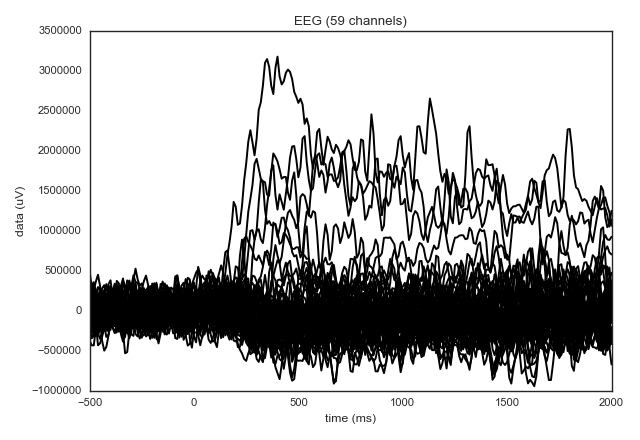

/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:52: DeprecationWarning: Comm._comm_id_default is deprecated: use @default decorator instead.
  def _comm_id_default(self):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:29: DeprecationWarning: Comm._iopub_socket_default is deprecated: use @default decorator instead.
  def _iopub_socket_default(self):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:24: DeprecationWarning: Comm._kernel_default is deprecated: use @default decorator instead.
  def _kernel_default(self):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:32: DeprecationWarning: Comm._session_default is deprecated: use @default decorator instead.
  def _session_default(self):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:41: DeprecationWarning: Comm._topic_default is deprecated: use @default decorator instead.
  def _topic_default(sel

In [51]:
# Let's look at the average plots again
f = epochs.average().plot()

Looking through the data, maybe you note some channels that are more "active" than others. AKA, ones that show a response when the sound begins (green lines are sound onsets). Let's look at one closer to see what it looks like.

<IPython.core.display.Javascript object>


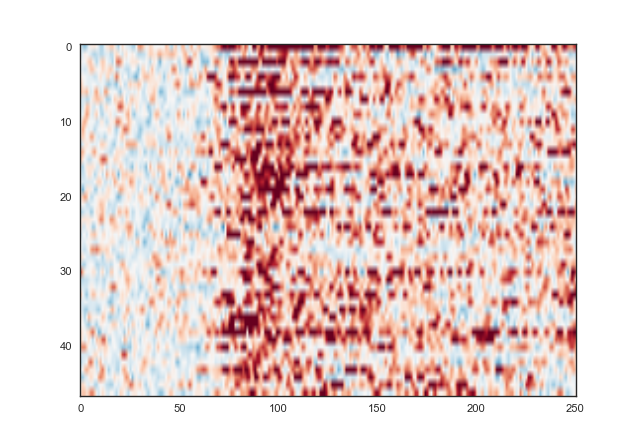

/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:52: DeprecationWarning: Comm._comm_id_default is deprecated: use @default decorator instead.
  def _comm_id_default(self):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:29: DeprecationWarning: Comm._iopub_socket_default is deprecated: use @default decorator instead.
  def _iopub_socket_default(self):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:24: DeprecationWarning: Comm._kernel_default is deprecated: use @default decorator instead.
  def _kernel_default(self):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:32: DeprecationWarning: Comm._session_default is deprecated: use @default decorator instead.
  def _session_default(self):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:41: DeprecationWarning: Comm._topic_default is deprecated: use @default decorator instead.
  def _topic_default(sel

In [53]:
# Another way to look at this is with an image.
# Here are the trial activations for one electrode:
# It looks like this channel is responsive
use_chan = 'TG37'
ix_elec = mne.pick_channels(epochs.ch_names, [use_chan])[0]
plt_elec = epochs._data[:, ix_elec, :]

f, ax = plt.subplots()
ax.imshow(plt_elec, aspect='auto', cmap=plt.cm.RdBu_r, vmin=-5, vmax=5)

You can see a clear increase in activity near t== 0 (500 on the xaxis above). So this seems like an electrode that **does** respond to sound.

I should note, this is one of the really powerful things about electrocorticography recordings. It allows you to see a clear effect on an individual trial. Most other methods in human neuroscience require you to average across many trials before anything clear pops up.

## Encoding models
OK, so now we know that this electrode responds to sound in general, but can we have a better idea for *what* it's responding to? To do this, we build an encoding model.

The basic idea behind an encoding model is *regression*. This is a technique where we attempt to predict a continuously-changing variable using features of our choosing.

We'll be using a version of regression called "linear" regression, because it's more tractable to run on a computer and it's much easier to interpret.

*"But the brain is crazy complicated, how can it be 'linear'?"* you say. That's a good point - we're actually going to take care of all the "non-linear" stuff by choosing what features we put into the model.

For example, we're going to predict activity of high-gamma amplitude. In extracting the high-gamma amplitude, we've already applied a bunch of non-linear modifications to the original signal.

In [18]:
# To do regression, we'll use a package called scikit-learn.
from sklearn.linear_model import Ridge

We're using a variant called "Ridge" regression, because it employs an extra technique called "regularization". We can talk about that later if you want.

In [19]:
# We create a model like this (note "alpha", that's the regularization parameter)
model = Ridge(alpha=1)
model

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

## On fake data...

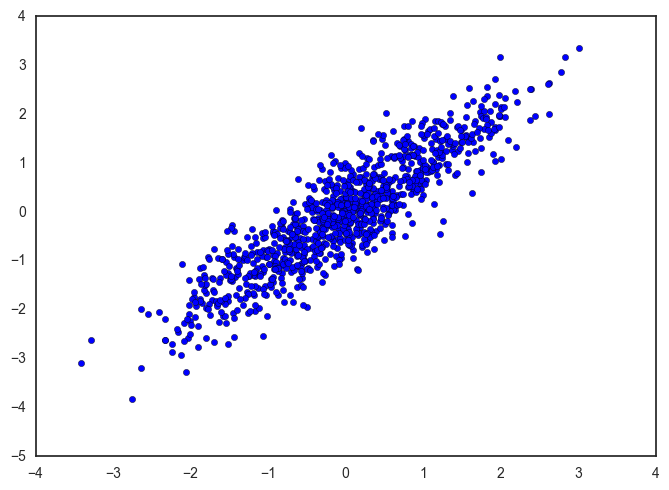

In [20]:
# Now we'll create some fake data to get the idea
x = np.random.randn(1000)
y = x + .5 * np.random.randn(1000)  # Add some slight noise to X
f, ax = plt.subplots()
ax.scatter(x, y)
f

In [21]:
# We can fit a "model" to predict y, given a value of X.
# We'll do this by feeding the data into our ridge model
model.fit(x[:, None], y[:, None])  # sklearn expects shape (n_points, n_feats)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

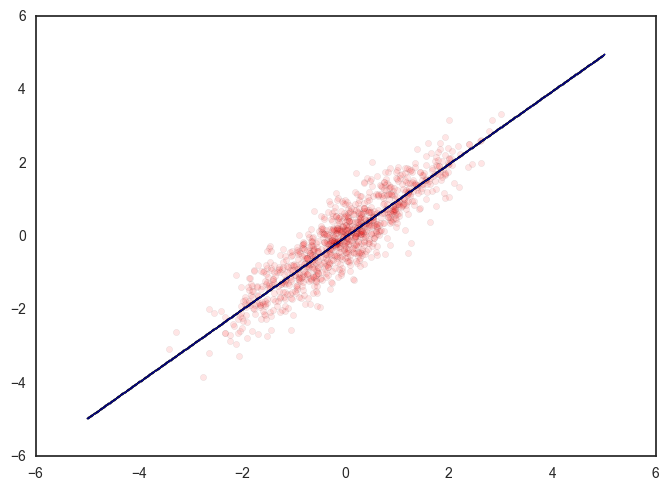

In [22]:
# Now, we can look at the line that the model fit
# We do this be defining a bunch of points that span the range of x
# and see what the model would predict
x_pred = np.linspace(-5, 5, 1000)
y_pred = model.predict(x_pred[:, None])
f, ax = plt.subplots()
ax.scatter(x, y, alpha=.1, c='r')
ax.scatter(x_pred, y_pred, s=1)
f

In [23]:
# We can also inspect the coefficient that the model uses to predict y
print(model.coef_)

[[ 0.99196218]]


It looks like the model correctly found the relationship between x and y. The coefficient we've printed above shows the "relationship" that the model has found between X and Y. A linear model means that it has one "weight" for each feature. It multiplies each feature with its weight, then sums them together. AKA:

$y = w*x$

In this case, the feature is "x" the weight is the coefficient above, and the output is "y". This tells how "y" will respond given a value in "x"

## On real data...but first, an audio primer
OK, now things are going to get a lot more complicated. Instead of fake data, we'll use brain data and auditory data. First, let's look at our auditory features. These are in a form called a "spectrogram", which is a way of breaking down sound into a collection of fast-moving things and slow-moving things.

/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


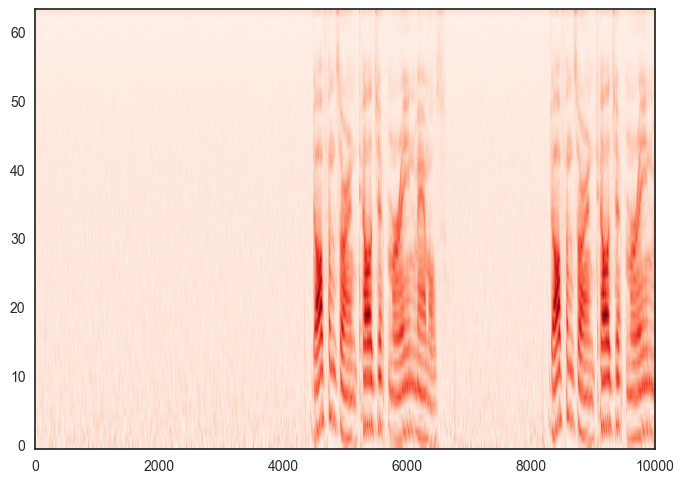

In [26]:
f, ax = plt.subplots()

# This will plot 10 seconds.
ax.imshow(audio._data[:, :10*audio.info['sfreq']],
          aspect='auto', origin='lower', cmap=plt.cm.Reds)
f

Those regions of "hot" colors show when the sound is present. Rows near the bottom are slow-moving parts of the sound, and rows near the top are fast-moving parts.

Maybe the presence of these spectral features can be used to predict the ecog activity. To address this question, we'll use the same regression technique. In this case, our inputs will be the spectrogram above (as X) and the output will be the high-gamma activity in the electrode (as y).

There is one extra step - we don't expect the brain to respond *immediately* to sounds in the world. That's because it takes time for the signal to get from your ears to your auditory cortex. As such, we'll include "time-lagged" versions of the above spectrogram as extra features in our model:

In [27]:
# First we'll cut up the data so that we don't overload memory
# We will create an "events" object by turning the start times into indices
# Then turning it into an array of shape (n_events, 3)
ev = mtime['start'] * audio.info['sfreq']
ev = np.vstack([ev, np.zeros_like(ev), np.ones_like(ev)]).astype(int).T
einfo = dict(myevent=1)

# Now we'll turn the raw array into epochs shape
tmin, tmax = -.5, 2
epochs_audio = mne.Epochs(audio, ev, einfo, tmin, tmax,
                          baseline=(None, 0), preload=True)

# We'll decimate the data because we've got more datapoints than we need
epochs_audio.decimate(10)

<Epochs  |  n_events : 47 (all good), tmin : -0.5 (s), tmax : 2.0 (s), baseline : (None, 0)>

In [28]:
# We'll now re-join the audio into a single timeseries
epochs_audio_data = np.hstack(epochs_audio._data)
print(epochs_audio_data.shape)

(64, 11797)


In [29]:
# Finally, we'll add the time lags
lags = np.arange(0, .4, .02)
epochs_audio_data = et.sig.delay_timeseries(epochs_audio_data, epochs_audio.info['sfreq'], lags)

# Note that we've multiplied our number of features by length(lags)
epochs_audio_data.shape

(1280, 11797)

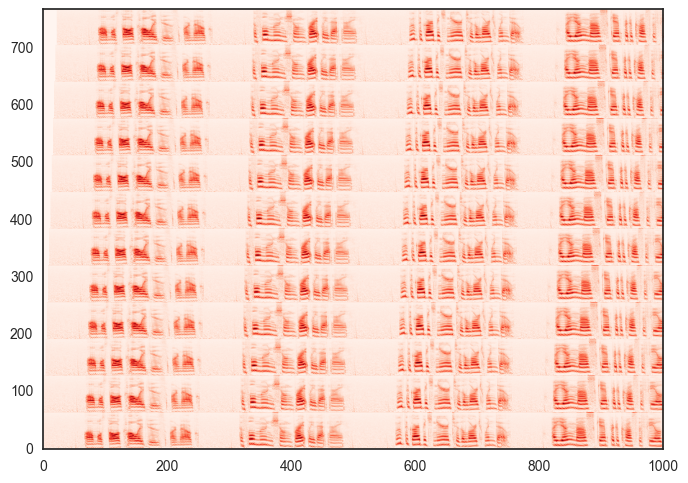

In [31]:
# Looking at the audio, we can clearly see the time lags
f, ax = plt.subplots()
ax.imshow(epochs_audio_data[:64*12, :1000], aspect='auto', origin='lower',
          cmap=plt.cm.Reds)
f

Remember, reach row is a feature, and each column is a datapoint. So our features are basically comprised of two things: a spectral "frequency" range, and a time-lag range. Thus, they are called **spectro-temporal** features.

In [32]:
# We'll also decimate the ecog data so it's the same length
epochs_fit = epochs.copy()
epochs_fit.decimate(10)
brain_data = np.hstack(epochs_fit._data[:, ix_elec, :])
print(brain_data.shape)

(11797,)


In [33]:
# Now we'll do the same thing as before, fitting a ridge regression model.
# We'll use a larger alpha value, because this data is a lot noisier
model = Ridge(alpha=1e5)
model.fit(epochs_audio_data.T, brain_data)

Ridge(alpha=100000.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

OK, we've fit the model using the spectrotemporal inputs, and the ecog output. Let's inspect it to understand what we've found.

In [34]:
# Now lets see what kind of a model we found.
# First we'll look at the model's predictions vs. the true data:
brain_pred = model.predict(epochs_audio_data.T)

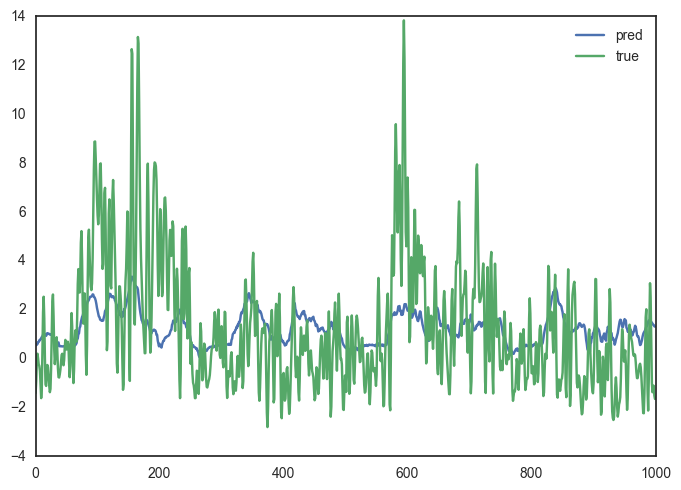

In [35]:
f, ax = plt.subplots()
ax.plot(brain_pred[:1000], label='pred')
ax.plot(brain_data[:1000], label='true')
ax.legend()
f

Clearly, there's a lot going on in the "true" data that the model isn't predicting. However, there do seem to be correspondences. Let's scale the two and see if this helps:

In [36]:
from sklearn.preprocessing import scale

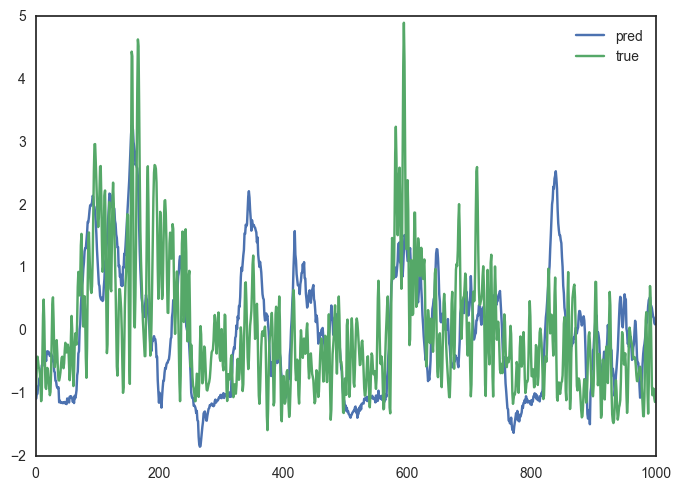

In [37]:
f, ax = plt.subplots()
ax.plot(scale(brain_pred[:1000]), label='pred')
ax.plot(scale(brain_data[:1000]), label='true')
ax.legend()
f

A little bit better - it does look like our model accurately predicts when the high-gamma activity will increase (it's just missing a lot of other stuff as well. Whether that is just "noise" that can't be modeled, or if it's the brain responding to other kinds of things, we don't know).

Finally, let's look at the coefficients that our model found. This tells us how the model thinks the brain is tuned to the spectrogram space.

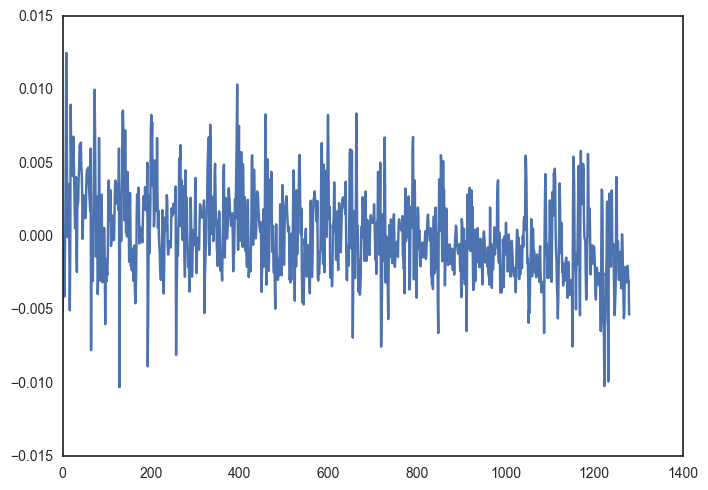

In [45]:
# The coefficients look messy, that's because they're actually meant
# To be represented as a 2D structure (features by time-lags)
f, ax = plt.subplots()
ax.plot(model.coef_)
f

Remember that there are two dimensions to our model coefficeints (because of the way that we chose our features). A frequency (spectral) dimension, and a time-lag (temporal) dimension. As such, we we can reshape this coefficient vector so that it is of shape (n_frequencies, n_time_lags). This is called a **spectrotemporal receptive field** or **STRF**.

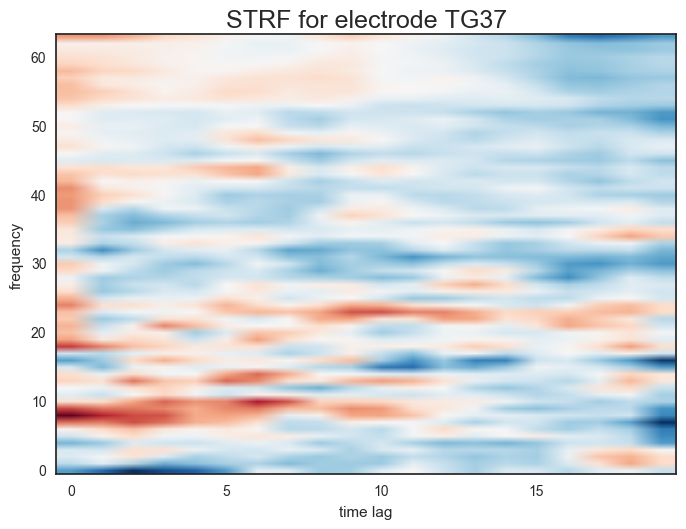

In [46]:
coefs = np.reshape(model.coef_, [len(lags), -1]).T
f, ax = plt.subplots()
ax.imshow(coefs, aspect='auto', origin='lower', cmap=plt.cm.RdBu_r)
ax.set_xlabel('time lag')
ax.set_ylabel('frequency')
ax.set_title("STRF for electrode {0}".format(use_chan), fontsize=18)
f

It looks like there are particular sub-regions within this space that our model has "selected". These are the parts of spectro-temporal space that the electrode responds to.

A **STRF** tells us how this electrode responds to these spectrotemporal features. Recall that this is a particularly "low-level" feature space. There isn't any obvious information in there about the kinds of things we associate with language (e.g., no idea what a "word" would be in this space).

If you want to know how this electrode responds to more complicated features, you would need to feed them as inputs to the model like we did above.

# Wrapping up
OK, so what have we learned here? We accomplished the following steps:

1. Look at raw brain data
1. Look at the raw activity in response to sound
1. Filter our brain data to extract high-gamma amplitude
1. See that high-gamma has a more reliable response to sound
1. Find an electrode that seemed particularly responsive
1. Create a time-lagged version of auditory features
1. Fit a model that predicted that electrode's activity, using those features
1. Observe that the model was able to predict activity correctly
1. Investigate the coefficients that the model found in order to understand what spectral features the electrode responds to.

That's a very, very tip-of-the-iceberg introduction to fitting encoding models in the brain, which is the flip-side to fitting "decoding" models in the brain. We'll go into more detail on that later.